<a id="top"></a>
# HSTaXe Cookbook: Extraction for WFC3/UVIS Full Frame G280 Data

This notebook contains a step-by-step guide for performing a basic spectral extraction with HSTaXe for G280 full frame data from WFC3/UVIS. <br>
The original source for this notebook is the "cookbook" folder on the [spacetelescope/hstaxe](https://github.com/spacetelescope/hstaxe) GitHub repository. 

***
## Learning Goals
In this tutorial, you will:

- Organize input data
- Set up HSTaXe and prepare data for extraction
- Learn how to handle different types of local background subtraction
- Extract 1-D spectra 
- Display the results

## Table of Contents

[1. Introduction](#intro) <br>
[2. Imports](#import) <br>
[3. Setup](#setup) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.1 Verify Matching WCS Information](#wcs) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.2 Drizzling Input Data](#drizzle) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.3 Creating a Catalog with SExtractor](#catalog) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.4 Copy Catalog and Rename Mag Column](#copycat)<br>
[4. Running HSTaXe](#axe) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.1. Outputs](#out) <br>
[5. Conclusions](#conclusions) <br>
[6. About this Notebook](#about) <br>
[7. Citations](#cite) 

## 1. Introduction <a id="intro"></a>

[HSTaXe](https://hstaxe.readthedocs.io/en/latest/index.html) is a Python package that provides spectral extraction processes for HST data. **Please be aware that running this notebook requires creating a conda environment from the provided `.yml` file in this notebook's [github repository](https://github.com/spacetelescope/hstaxe/tree/main/cookbooks).** For more details about creating the necessary environment see the notebook's README file.

Below, we show the workflow for a basic specral extraction using WFC3/UVIS full frame G280 grism data. **The example data we use in this notebook are available [here](https://stsci.box.com/s/x0ndoduqkqd1ys1u9fgsz32urizsjdks).** If you would like to use this notebook with the example data, please dowload all required data in the `example_data` subdirectory from the link above, and store it within the same parent directory as this notebook. Once you have the example data directory, this notebook is intended to run continuously without needing to edit any of the cells. 

In addition to the grism and direct image data, **this notebook also requires configuration files for HSTaXe, which can be downloaded [here](https://stsci.box.com/s/ojbj3v4twkpkqt6tj9hwg1xkzbhrugm4).** Please download the folder titled `WFC3_UVIS_conf`. This configuration directory should be stored in the  same parent directory as this notebook, and later we will be copy them to the `CONF` subdirectory created by HSTaXe.

**If you plan to use your own data with this notebook, please be aware you will be required to create an input source catalog with SExtractor.** Information regarding SExtractor including installation instructions are available [here](https://sextractor.readthedocs.io/en/latest/Installing.html). In addition to installing SExtractor, you must run the software with aXe specific configuration files. **These aXe-SExtractor configuration files can be downloaded [here](https://stsci.box.com/s/3npry36gu7ocfnuxgzwr5syj4i8r7hy8).** Once SExtractor is installed, create a `sextractor` directory in the same parent directory as this notebook, and place configuration files inside. 

## 2. Imports <a id="import"></a>

For this workflow, we will import the following modules:

- *os*, *glob* and *shutil*, for file handling
- *numpy* for array handling
- *astropy.io.fits* for FITS file handling
- *matplotlib.pyplot* for plotting
- *ginga.util.zscale* for calculating zscale limits for image display
- *astrodrizzle* for creating input image mosaics
- *hstaxe.axetasks* for performing the spectral extraction


In [1]:
%matplotlib inline

import glob
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
from astropy.io import fits, ascii
from astropy.table import Table
from ginga.util import zscale

from drizzlepac import astrodrizzle
from hstaxe import axetasks



The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol
Saving hstaxe logging to 'axe_output.log'

*********************************************************************
* Welcome to hstaxe!
This version is independent of IRAF and PyRAF. *
*********************************************************************

AXE_IMAGE_PATH already exists, using.
AXE_OUTPUT_PATH already exists, using.
AXE_CONFIG_PATH already exists, using.
AXE_DRIZZLE_PATH already exists, using.
AXE_SIMDATA_PATH already exists, using.
AXE_OUTSIM_PATH already exists,

## 3. Setup <a id="setup"></a>

We'll start our basic extraction workflow by organizing our input data using the `example_data` directory downloaded from the link in the [Introduction](#intro). 

First, we save the working directory for this notebook.

In [2]:
cwd = os.getcwd()
print(f'The current directory is: {cwd}')

The current directory is: /Users/bkuhn/gitRepos/hstaxe/hstaxe/cookbooks/basic-uvis_ff


Next, we'll create directories for our grism and direct images. **HSTaXe will modify our input images in-place, so it is crucial to retain clean versions of them in another location, which will be copied into these directories.** If running this notebook multiple times, run all the lines in the next cell to clear any existing inputs.

In [3]:
os.chdir(cwd)
if os.path.isdir('grism_ims'):
    shutil.rmtree('grism_ims')
if os.path.isdir('direct_ims'):
    shutil.rmtree('direct_ims')
os.mkdir('grism_ims')
os.mkdir('direct_ims')

Now, let us copy the full frame UVIS images to the input directories.

In [4]:
# src = '/path/to/your/grism/images/*.fits'
src = 'example_data/grism/*flc.fits'
dst = 'grism_ims/'
for f in glob.glob(src):
    shutil.copy(f, dst)

# src = '/path/to/your/direct/images/*.fits'
src = 'example_data/direct/*flc.fits'
dst = 'direct_ims/'
for f in glob.glob(src):
    shutil.copy(f, dst)

## 3.1  Verify Matching WCS Information <a id="wcs"></a>

It is possible that the WCS in the direct and grism images differ. In this section we will use a function to process all the direct and grism images to verify that the WCS information is consistent throughout. If there is any disagreement in WCS information we call `updatewcs` with the database keyword set to False, which will roll back all the solutions to the original distortion-corrected WCS. For more information regarding HST WCS and improved absolute astrometry please see [WFC3 Instrument Science Report 2022-06](https://ui.adsabs.harvard.edu/abs/2022wfc..rept....6M/abstract) (Mack et al. 2022). For documentations on `updatewcs` please see [here](https://stwcs.readthedocs.io/en/latest/updatewcs.html).

Before running `updatewcs`, we need to [set CRDS environment variables](https://hst-crds.stsci.edu/docs/cmdline_bestrefs/).  We will point to a subdirectory called `crds_cache/` using the `IREF` environment variable. The `IREF` variable is used for WFC3 reference files and different instruments use other variables, e.g., `JREF` for ACS.

You have the option to permanently add these environment variables to your user profile by adding the path in your shell's configuration file. If you're using bash, you would edit the `~/.bash_profile` file with lines such as:
```
export CRDS_PATH="$HOME/crds_cache"
export CRDS_SERVER_URL="https://hst-crds.stsci.edu"
export iref="${CRDS_PATH}/references/hst/iref/"
```
If you have already set up the CRDS environment variables you may skip running the cell below. 

In [5]:
os.environ["CRDS_SERVER_URL"] = "https://hst-crds.stsci.edu"
os.environ['CRDS_SERVER'] = 'https://hst-crds.stsci.edu'
if "CRDS_PATH" not in os.environ.keys():
    os.environ["CRDS_PATH"] = os.path.join(os.environ["HOME"],"crds_cache")
if "iref" not in os.environ.keys():
    os.environ["iref"] = "$HOME/crds_cache/references/hst/iref/"

In [6]:
def check_wcs(images):
    """ A helper function to verify the active world coordinate solutions match and roll them back if they do not 
    
    Parameter
    ---------
    images : list 
        a list of grism and direct images 
        
    Return
    ------
    N/A
    """
    
    direct_wcs = []
    grism_wcs = []

    for f in images:
        # get filter for image to distinguish between direct and grism
        filt = fits.getval(f, 'FILTER')
       
        hdul = fits.open(f)
        db_bool = 'WCSCORR' not in hdul
        hdul.close()
        
        try:
            # get the active solution from the file's "SCI" extension
            wcsname = fits.getval(f, 'WCSNAME', ext=('SCI', 1))
            if db_bool == True:
                updatewcs.updatewcs(f,use_db=db_bool)
        except KeyError:
            updatewcs.updatewcs(f,use_db=db_bool)
            wcsname = fits.getval(f, 'WCSNAME', ext=('SCI', 1))
        
        # seperate between direct and grism
        if 'G' in filt:
            grism_wcs.append(wcsname)
        if 'F' in filt:
            direct_wcs.append(wcsname)

    # get the number of unique active solutions in the direct and grism images       
    num_wcs_direct = len(set(direct_wcs))
    num_wcs_grism = len(set(grism_wcs))
    
    # roll back WCS on all files if there is more than one active solution for either direct or grism images
    if num_wcs_direct > 1 or num_wcs_grism > 1:
        [updatewcs.updatewcs(file,use_db=False) for file in images]
        print('WCS reset complete')

    # roll back WCS on all files if the active solution for the direct images do not match the grism images
    elif set(direct_wcs) != set(grism_wcs):
        [updatewcs.updatewcs(file,use_db=False) for file in images]
        print('WCS reset complete')

    # do nothing if there is one unique active solution and they match
    elif set(direct_wcs) == set(grism_wcs):
        print(f"No WCS update needed. All grism and direct images us WCS: {grism_wcs[0]}.")
        

The cell below also calls [CRDS bestref](https://hst-crds.stsci.edu/static/users_guide/basic_use.html), which will copy the necessary reference files from CRDS over to your local machine, if you do not already have them.

In [7]:
all_images = glob.glob('direct_ims/i*_flc.fits')+\
             glob.glob('grism_ims/i*_flc.fits')

for image in all_images:
    command_line_input = f'crds bestrefs --files {image} --types IDCTAB MDRIZTAB --sync-references=1 --update-bestrefs'
    os.system(command_line_input)
        
check_wcs(all_images)

CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing direct_ims/ibr502i6q_flc.fits
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos
CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing grism_ims/ibr502ibq_flc.fits
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos
CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing grism_ims/ibr502icq_flc.fits
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos
CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing grism_ims/ibr502i9q_flc.fits
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  2 infos


No WCS update needed. All grism and direct images us WCS: IDC_yas1621ai.


## 3.2 Drizzling the Input Data<a id="drizzle"></a>
The next step is to drizzle the grism images. We'll need a list of the image names to feed to AstroDrizzle. After that, we'll do the same for the direct images, but use the drizzled grism image as a reference, which will ensure proper registration between the data. HSTaXe will use these linked drizzle images to locate spectral traces based on the positions of sources in the direct images.

In [8]:
# Creat list file using images in grism directory
os.chdir('grism_ims')

lis = open('grism.lis', 'w')
for f in sorted(os.listdir('.')):
    if os.path.splitext(f)[1]=='.fits':
        lis.write(f)
        lis.write('\n')
lis.close()

!cat grism.lis

ibr502i9q_flc.fits
ibr502ibq_flc.fits
ibr502icq_flc.fits


In [9]:
# Drizzle grism images. If only using one input image, set blot, median, driz_cr to False
astrodrizzle.AstroDrizzle('@grism.lis', output='grism', mdriztab=True, 
                          preserve=False, skysub=True, skymethod= 'match', final_fillval=None)

Setting up logfile :  astrodrizzle.log
AstroDrizzle log file: astrodrizzle.log
AstroDrizzle Version 3.5.1 started at: 12:46:25.214 (31/03/2023)

==== Processing Step  Initialization  started at  12:46:25.216 (31/03/2023)

Reading in MDRIZTAB parameters for 3 files
- MDRIZTAB: AstroDrizzle parameters read from row 5.
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 216.19745014595364  46.24051523168919  
CRPIX : 2062.5  2193.0  
CD1_1 CD1_2  : -1.0431841042161617e-05  3.50698600951705e-06  
CD2_1 CD2_2  : 3.50698600951705e-06  1.0431841042161617e-05  
NAXIS : 4125  4386
********************************************************************************
*
*  Estimated memory usage:  up to 1626 Mb.
*  Output image size:       4125 X 4386 pixels. 
*  Output image file:       ~ 207 Mb. 
*  Cores available:         6
*
********************************************************************************
==== Processing Step Initialization finished at 12:46:27.464 (31/03/2

Writing out image to disk: ibr502icq_single_sci.fits
Writing out image to disk: ibr502i9q_single_sci.fits
Writing out image to disk: ibr502ibq_single_sci.fits
Writing out image to disk: ibr502ibq_single_wht.fits
Writing out image to disk: ibr502icq_single_wht.fits
Writing out image to disk: ibr502i9q_single_wht.fits
==== Processing Step Separate Drizzle finished at 12:46:31.193 (31/03/2023)
==== Processing Step  Create Median  started at  12:46:31.195 (31/03/2023)

reference sky value for image 'ibr502i9q_flc.fits' is 0.0
reference sky value for image 'ibr502ibq_flc.fits' is 0.0
reference sky value for image 'ibr502icq_flc.fits' is 0.0
Saving output median image to: 'grism_med.fits'
==== Processing Step Create Median finished at 12:46:37.078 (31/03/2023)
==== Processing Step  Blot  started at  12:46:37.079 (31/03/2023)

    Blot: creating blotted image:  ibr502i9q_flc.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: ibr502i9q_sci1_blt.fits


==== Processing Step Final Drizzle finished at 12:46:56.49 (31/03/2023)

AstroDrizzle Version 3.5.1 is finished processing at 12:46:56.492 (31/03/2023).



   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          2.2484 sec.
            Static Mask          1.1625 sec.
           Subtract Sky          0.0882 sec.
       Separate Drizzle          2.4744 sec.
          Create Median          5.8830 sec.
                   Blot          5.6972 sec.
                Driz_CR          2.3360 sec.
          Final Drizzle          11.3695 sec.
   ====================          ====================
                  Total          31.2592 sec.

Trailer file written to:  astrodrizzle.log


In [10]:
# List file for direct images
os.chdir(cwd)
os.chdir('direct_ims')

lis = open('direct.lis', 'w')
for f in sorted(os.listdir('.')):
    if os.path.splitext(f)[1]=='.fits':
        lis.write(f)
        lis.write('\n')
lis.close()

!cat direct.lis

ibr502i6q_flc.fits


Next, drizzle the direct images using the drizzled grism mosaic as a reference to ensure proper registration. Note, in the cell below we have set the `AstroDrizzle` parameters for processing only a single image. **If you have more than one direct image to drizzle together please set the parameters appropriately.** For example `driz_separate`, `driz_sep_wcs`, `median`, `blot`, and `driz_cr` should all be set to `True`. For more information please see the `AstroDrizzle` documentation [here](https://drizzlepac.readthedocs.io/en/latest/astrodrizzle.html). Finally, if your input images were flt images rather than flc images, change the extension to `drz.fits` in the cell below.

In [11]:
ref = '../grism_ims/grism_drc.fits[1]'
astrodrizzle.AstroDrizzle("@direct.lis", output="direct", build=True, in_memory=False, preserve = False, 
                          skysub=True, skymethod= 'match', driz_separate=False, median=False, blot=False, driz_cr=False,
                          final_wcs=True, final_refimage=ref)

Setting up logfile :  astrodrizzle.log
AstroDrizzle log file: astrodrizzle.log
AstroDrizzle Version 3.5.1 started at: 12:46:56.711 (31/03/2023)

==== Processing Step  Initialization  started at  12:46:56.713 (31/03/2023)

Creating OUTPUT WCS from ../grism_ims/grism_drc.fits[1]
WCS Keywords

CD_11  CD_12: -1.0431841042161e-05 3.50698600951705e-06
CD_21  CD_22: 3.50698600951705e-06 1.04318410421616e-05
CRVAL    : 216.1974501459536 46.24051523168919
CRPIX    : 2062.5 2193.0
NAXIS    : 4125 4386
Plate Scale : 0.03962000086903362
ORIENTAT : 18.5816628435462
********************************************************************************
*
*  Estimated memory usage:  up to 271 Mb.
*  Output image size:       4125 X 4386 pixels. 
*  Output image file:       ~ 207 Mb. 
*  Cores available:         1
*
********************************************************************************
==== Processing Step Initialization finished at 12:46:56.981 (31/03/2023)
==== Processing Step  Static Mask  starte

Your grism and direct images should now be aligned. For the WFC3/UVIS grisms, there will be some vertical and horizontal offset between the positions of sources in the direct image and their correspondents in the grism image. For more information about G280 including appearance on the detector, please see WFC3 Instrument Handbook Section 8.2 ["Slitless Spectroscopy with the UVIS G280 Grism"](https://hst-docs.stsci.edu/wfc3ihb/chapter-8-slitless-spectroscopy-with-wfc3/8-2-slitless-spectroscopy-with-the-uvis-g280-grism). We'll perform a quick visual check here:

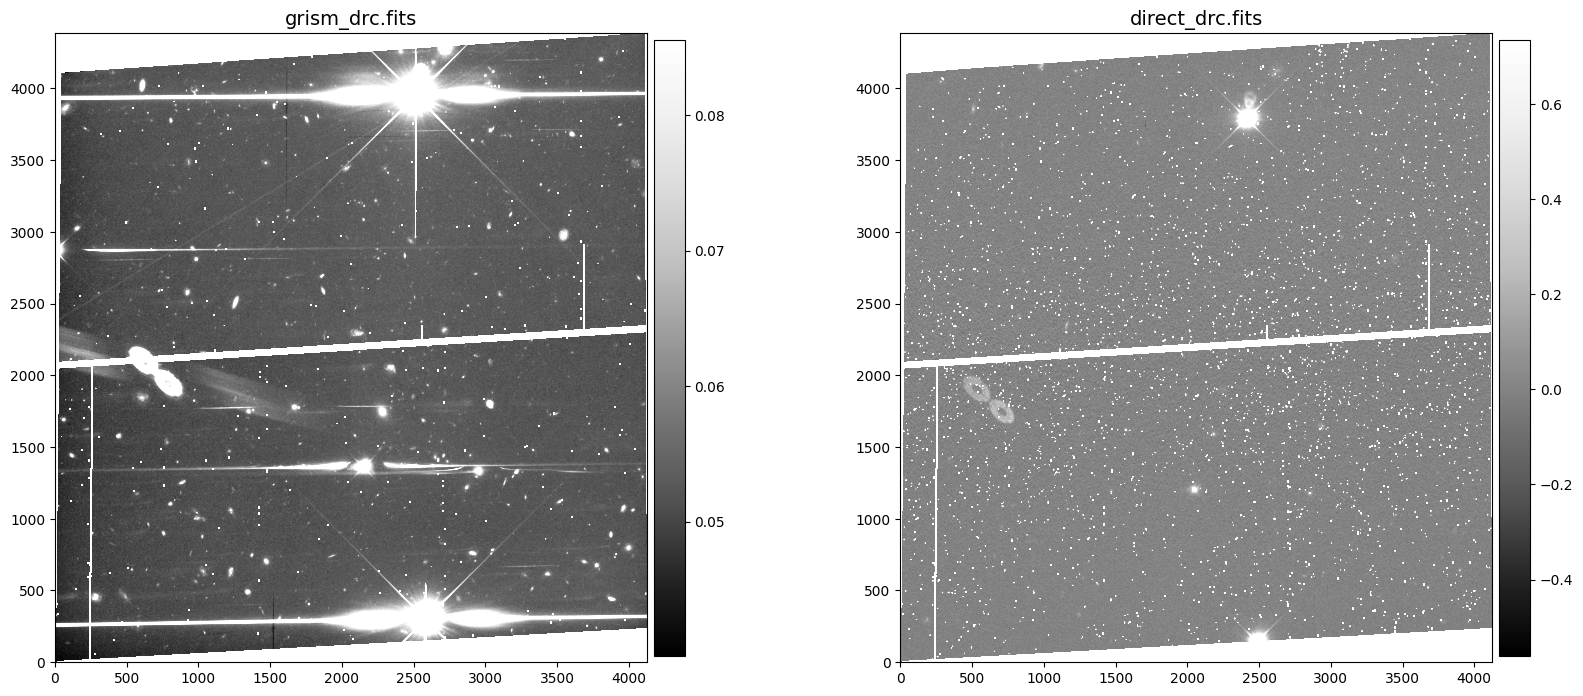

In [12]:
os.chdir(cwd)

fig, axes = plt.subplots(1, 2, figsize=(20,20))

d = fits.getdata('grism_ims/grism_drc.fits', 1)
z1,z2 = zscale.zscale(d)
im1 = axes[0].imshow(d, origin='lower',cmap='Greys_r', vmin=z1, vmax=z2)
axes[0].set_title('grism_drc.fits',size=14)
fig.colorbar(im1,shrink=0.4,pad=0.01)

d = fits.getdata('direct_ims/direct_drc.fits', 1)
z1,z2 = zscale.zscale(d)
im2 = axes[1].imshow(d, origin='lower',cmap='Greys_r', vmin=z1, vmax=z2)
axes[1].set_title('direct_drc.fits',size=14)
fig.colorbar(im2,shrink=0.4,pad=0.01)

## 3.3 Creating a Catalog with SExtractor <a id="catalog"></a>

This section is intended for anyone using data other than the `example_data` provided for this notebook. Since we also provide a catalog in the `example_data` directory and will not formally run SExtractor here, we want to explain the process behind using the drizzle image to create a new catalog with SExtractor. **Please refer to the links in the [Introduction](#intro) section for instructions regarding installing SExtractor and downloading the necessary aXe-SExtractor configuration files.**

HSTaXe will look for a highly specific format in the catalog, and does not always give clear error messages when something within the catalog is awry. If creating a catalog yourself, please follow the next steps carefully:

1. Copy the drizzled direct image into the `sextractor` directory (once created), which contains HSTaXe-appropriate configuration files for SExtractor.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<u>Example code:</u>
```python
shutil.copy('direct_ims/direct_drz.fits', 'sextractor/')
```
2. With SExtractor installed, run the following command from within the `sextractor` directory that you created:
   
   `sex -c aXe.sex direct_drz.fits[1] -DETECT_THRESH 5 -MAG_ZEROPOINT 26.4525`

    Note that the value for the `DETECT_THRESH` keyword, which sets the minimum value for pixels to be considered, may be changed appropriately for your data. Similarly, `MAG_ZEROPOINT` corresponds to the UVIS zeropoint in AB mags. When using the UVIS grism there are generally only two main direct image filters to choose from, F200LP and F300X. For photometric information and filter zeropoints please see our [photometric calibration webpage](https://www.stsci.edu/hst/instrumentation/wfc3/data-analysis/photometric-calibration/uvis-photometric-calibration).
    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<u>Example code:</u>
```python
os.chdir('sextractor')
detect_thresh = 50
mag_zp = 27.336
cl_input = f'sex -c aXe.sex direct_drz.fits[1] -DETECT_THRESH {detect_thresh} -MAG_ZEROPOINT {mag_zp}'
os.system(cl_input)
``` 
3. At this point you should have created a catalog. The next steps include copying the file into the `direct_ims` directory and editing the name of the `MAG_ISO` column. See [Section 2.4](#copycat) for information regarding renaming the `MAG_ISO` column. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<u>Example code:</u>
```python
os.chdir(cwd)
shutil.copy('sextractor/aXe.cat', 'direct_ims')
```

## 3.4 Copy Catalog and Rename Mag Column <a id="copycat"></a>

The catalog corresponding to the data used in this notebook is included in the `example_data` directory downloaded in the Introduction section. Start by copying the catalog into the `direct_ims` directory.

In [13]:
# Copy the example catalog to the direct image directory:
os.chdir(cwd)
shutil.copy('example_data/aXe.cat', 'direct_ims')

'direct_ims/aXe.cat'

In [14]:
cat = Table.read('direct_ims/aXe.cat', format='ascii.sextractor')
cat

X_IMAGE,Y_IMAGE,NUMBER,X_WORLD,Y_WORLD,A_IMAGE,B_IMAGE,THETA_IMAGE,A_WORLD,B_WORLD,THETA_WORLD,FLUX_RADIUS,MAG_ISO,MAGERR_ISO
pix,pix,,deg,deg,pix,pix,deg,deg,deg,deg,pix,mag,mag
float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2484.9175,144.0776,2,216.18069568,46.220621389,1.196,0.426,64.73,1.250238e-05,6.245268e-06,-81.3,2.617,18.0089,0.0001
2054.595,1198.0911,3,216.19252325,46.230108217,0.649,0.45,89.54,7.140071e-06,4.958207e-06,71.8,1.253,18.3624,0.0001
2413.5571,3781.2051,4,216.20020921,46.258314253,2.394,0.495,89.11,2.6297e-05,5.679932e-06,72.15,3.31,17.8301,0.0001


Examine the catalog. The "MAG_ISO" column must be renamed to "MAG_F####" for the catalog to be correctly read in by HSTaXe. Where "####" is the pivot wavelength of the direct image filter in Å (and nm for WFC3/IR e.g. 4971 for F200LP and 1392 for F140W). Please see the [WFC3/UVIS photometic calibration webpage](https://www.stsci.edu/hst/instrumentation/wfc3/data-analysis/photometric-calibration/uvis-photometric-calibration) for pivot wavelengths, which are listed in the `PHOTPLAM` column in the accordion container. 

Any lines in the catalog containing clearly spurious detections, such as those with magnitudes of $\pm$99, should also be removed. **Note**: Removing spurious detections is not apart of this notebook and will need to be done manually. 

Lastly, locate the lines containing the sources whose spectra you want to extract and note the line number from the NUMBER column. This will be used later to identify the BEAM number for your object in the output files.

To avoid having to edit the column information manually in the SExtractor catalog, there is a helper function below called `edit_catalog_pivot`. It takes in the SExtractor catalog, output file path/name, and the pivot wavelength value and edits the information and writes to the output file. 

In [15]:
def edit_catalog_pivot(inputfile, outputfile, pivot_wave):
    """ Function to edit the auto-generated sextractor header/column name so aXe will run
        
        Parameters
        ----------
        inputfile : str
            The full path to the input catalog including filename
        outputfile : str
            The full path to the output catalog including filename
        pivot_wave : int or str
            The pivot wavelength of filter used in the driect image
            For UVIS please use 4 digits in units of Angstrom and 
            for IR please use 4 ditits in units of nanometers 
            
        Return
        ------
        Nothing. But a file is written to `outputfile`
    """
    # Read in the input catalog
    with open(inputfile, 'r') as f:
        lines = f.readlines()

    with open(outputfile, 'w') as f:
        # Find the mag_iso row and replace with pivot wavelength
        for line in lines:
            line = line.replace('MAG_ISO', f'MAG_F{pivot_wave}')
            f.write(line)

If you are using your own data, edit lines 1-3 in the cell below with your file paths and pivot wavelength. 

In [16]:
inputfile = 'direct_ims/aXe.cat'
outputfile = 'direct_ims/aXe_uvis_f200lp.cat'
pivot_wave = 4971 #angstrom because UVIS 
edit_catalog_pivot(inputfile, outputfile, pivot_wave)

Open the new catalog with the renamed column and inspect it to make sure it looks good.

In [17]:
# Use this cell to filter your catalog for your sources
# In this example, we sort to identify the brightest sources
cat = Table.read(outputfile, format='ascii.sextractor')
cat.sort('MAG_F4971')
cat[['NUMBER','X_IMAGE','Y_IMAGE','A_IMAGE','B_IMAGE','THETA_IMAGE','FLUX_RADIUS','MAG_F4971']]

NUMBER,X_IMAGE,Y_IMAGE,A_IMAGE,B_IMAGE,THETA_IMAGE,FLUX_RADIUS,MAG_F4971
,pix,pix,pix,pix,deg,pix,mag
int64,float64,float64,float64,float64,float64,float64,float64
4,2413.5571,3781.2051,2.394,0.495,89.11,3.31,17.8301
2,2484.9175,144.0776,1.196,0.426,64.73,2.617,18.0089
3,2054.595,1198.0911,0.649,0.45,89.54,1.253,18.3624


## 4. Running HSTaXe<a id="aXe"></a>

Below, we show an example of using HSTaXe to complete a basic extraction. If you are interested in seeing an example of a more advanced extraction method that utilizes a fluxcube, please see the WFC3/IR cookbook [here](https://github.com/spacetelescope/hstaxe/tree/main/cookbooks/WFC3).<br>

With the catalog generated and edited, we can now move on to working with HSTaXe. We'll set up a few additional directories and environment variables that point to them, while clearing out any previous data or outputs in these directories. We'll also copy our data into the fresh `DATA` directory.

In [18]:
os.chdir(cwd)

for dirr in ['DATA','CONF','OUTPUT']:
    if os.path.isdir(dirr):
        shutil.rmtree(dirr)
    os.mkdir(dirr)

os.environ['AXE_IMAGE_PATH'] = './DATA/' 
os.environ['AXE_CONFIG_PATH'] = './CONF/' 
os.environ['AXE_OUTPUT_PATH'] = './OUTPUT/' 

dsrc = 'direct_ims/*flc.fits'
gsrc = 'grism_ims/*flc.fits'
csrc = 'WFC3_UVIS_conf/*'

for files in [dsrc, gsrc, csrc]:
    if '_ims' in files:
        dirr = 'DATA'
    elif 'conf' in files:
        dirr = 'CONF'
    for f in glob.glob(files):
        shutil.copy(f, dirr)
    

Now we'll run `iolprep` to generate our IOLs, which are object catalogs for each individual direct image, from the drizzled direct image and its catalog.

In [19]:
os.chdir(cwd)
os.chdir('direct_ims')

axetasks.iolprep(drizzle_image = 'direct_drc.fits',
                input_cat = 'aXe_uvis_f200lp.cat')

In [20]:
# Copy the IOLs to the aXe DATA directory
os.chdir(cwd)
for f in glob.glob('direct_ims/*_?.cat'):
    print(f)
    shutil.copy(f, 'DATA')

direct_ims/ibr502i6q_flc_2.cat
direct_ims/ibr502i6q_flc_1.cat


The last step before extracting the spectra is to generate a file which contains on each line the names of a grism image, IOL name, and associated direct image. This is best done manually, to ensure that each grism image lines up with the appropriate direct image. For the example data, a file called `aXe.lis` is provided. With this list, we run `axeprep`, which prepares the individual images for spectral extraction. 

Note that the naming convention in `aXe.lis` is different for UVIS than IR because UVIS has two CCD chips. When using full frame UVIS data, the correct format for each line of `aXe.lis` is the name of the grism image, the object catalog for UVIS2 followed by the object catalog for UVIS1 separated by a comma, and then the corresponding direct image. IOLs for UVIS2 end with `_1.cat` while UVIS1 IOLs end with `_2.cat`.

In [21]:
# Uncomment below to copy and rename the example list file
os.chdir(cwd)
shutil.copy('example_data/aXe.lis', '.')

'./aXe.lis'

In [22]:
os.chdir(cwd)
!cat aXe.lis

ibr502i9q_flc.fits ibr502i6q_flc_1.cat,ibr502i6q_flc_2.cat ibr502i6q_flc.fits
ibr502ibq_flc.fits ibr502i6q_flc_1.cat,ibr502i6q_flc_2.cat ibr502i6q_flc.fits
ibr502icq_flc.fits ibr502i6q_flc_1.cat,ibr502i6q_flc_2.cat ibr502i6q_flc.fits

With this list, we run `axeprep`, which prepares the individual images for spectral extraction. This step is also responsible for perfoming a global background subtraction, however at the time of writing this notebook there is no UVIS sky background reference file and therefore the global background subtraction is not applicable. A UVIS sky background reference file is currently being created and we will update this section when it is released.

Note that the configuration files are listed in the same order below in `axeprep` as they are in the `aXe.lis` file; UVIS2 followed by UVIS1. Also note that HSTaXe needs the data in units of electrons per second and UVIS data is in units of electrons. Therefore the argument `norm` in `axeprep` must be set to `True` in order to have HSTaXe divide by the image's exposure time. 

In [23]:
os.chdir(cwd)

axetasks.axeprep(inlist="aXe.lis",
                 configs="WFC3.UVIS.G280.CHIP2.V2.0.conf,WFC3.UVIS.G280.CHIP1.V2.0.conf",
                 backgr=False,
                 backims=None,
                 norm=True,
                 mfwhm=3.0)

The last HSTaXe task to run is `axecore`, which performs the actual extraction and generates output files. 

Local background subtraction is also performed by this step, if desired. The following keywords are critical for local background:

* `back`: This argument, when set to TRUE, is the flag to trigger local background subtraction.
* `np`: Defines the number of pixels on either side of the spectral trace (beam) used to calculate the local background from.
* `interp`: Sets the interpolation method for the local background (-1=median, 0=mean, ≥1=nth order polynomial)
* `backfwhm`: The FWHM specifying the width of the background pixel extraction table

More information on background handling, both global and local, with `HSTaXe` can be found in the documentation [here](https://hstaxe.readthedocs.io/en/latest/hstaxe/description.html#sky-background). 

In addition to local background subtraction, HSTaXe is also able to perform a vertical extraction. This method of extraction requires editing the `THETA_IMAGE` column to `-90.0` in the object catalog (aXe.cat) and setting two keywords in `axecore`: `orient=True` and `slitless_geom=False`. Vertical extractions have been used in the past to handle the extreme curvature of the orders. For more information on the vertical extraction method please see [WFC3 ISR 2011-18](https://ui.adsabs.harvard.edu/abs/2011wfc..rept...18R/abstract) (Rothberg et al. 2011).

In [24]:
# Run axecore with no local background subtraction
axetasks.axecore('aXe.lis',
                 configs="WFC3.UVIS.G280.CHIP2.V2.0.conf,WFC3.UVIS.G280.CHIP1.V2.0.conf",
                 fconfterm=None,
                 extrfwhm=4.,
                 drzfwhm=3.,
                 orient=False,
                 weights=True,
                 slitless_geom=False,
                 cont_model='gauss',
                 sampling='drizzle',
                 exclude=True,
                 back=False)


Writing non-linear coefficients to file: DATA/ibr502i9q_flc_coeffs2.dat


Storing non-linear coefficients: 
WFC3: UVIS

DRZSCALE set to: 0.03962000086903572



Writing non-linear coefficients to file: DATA/ibr502ibq_flc_coeffs2.dat


Storing non-linear coefficients: 
WFC3: UVIS

DRZSCALE set to: 0.03962000086903572



Writing non-linear coefficients to file: DATA/ibr502icq_flc_coeffs2.dat


Storing non-linear coefficients: 
WFC3: UVIS

DRZSCALE set to: 0.03962000086903572



Writing non-linear coefficients to file: DATA/ibr502i9q_flc_coeffs2.dat


Storing non-linear coefficients: 
WFC3: UVIS

DRZSCALE set to: 0.03962000086903572



Writing non-linear coefficients to file: DATA/ibr502ibq_flc_coeffs2.dat


Storing non-linear coefficients: 
WFC3: UVIS

DRZSCALE set to: 0.03962000086903572



Writing non-linear coefficients to file: DATA/ibr502icq_flc_coeffs2.dat


Storing non-linear coefficients: 
WFC3: UVIS

DRZSCALE set to: 0.03962000086903572


## 4.1. Outputs<a id="out"></a>

Each grism input file will have several corresponding output files. For each of the G280 input FLT file, HSTaXe will create the following in the `OUTPUT/` directory:

- \<ipppssoot>_flt_2.cat          : Object catalog for the FLT file [ipppssoot]_flt.fits<br>
- \<ipppssoot>_flt_2.OAF          : Aperture file<br>
- \<ipppssoot>_flt_2.PET.fits     : The Pixel Extraction Table, containing all the unbinned information about each spectrum<br>
- \<ipppssoot>_flt_2.SPC.fits     : 1D extracted spectra<br>
- \<ipppssoot>_flt_2.CONT.fits    : Contamination estimate for eact of the spectra<br>
- \<ipppssoot>_flt_2_opt.SPC.fits : Optimally extracted version of the 1D spectra

For now, let's take a look at the STP files, which contain 2D "stamps" of the extracted spectral traces; and the SPC files, which contain our 1D extracted spectra. For all of the output files, those with the number 2 in their filename e.g. `ibr502i9q_flc_2.STP.fits` corresponds to data on UVIS2 and those with the number 5 in their filename e.g. `ibr502i9q_flc_5.SPC.fits` corresponds to data on UVIS1. 

We'll need the line numbers from the original source catalog we generated to identify the BEAM number for the objects whose spectra we want. For the example data, we'll use the target in the middle of UVIS2, which is number 3 in the provided catalog.

We'll first look at the STP files:

In [25]:
!ls -ltr OUTPUT/*_?.SPC.fits
!ls -ltr OUTPUT/*_?.STP.fits

-rw-r--r--  1 bkuhn  STSCI\science  190080 Mar 31 12:47 OUTPUT/ibr502i9q_flc_5.SPC.fits
-rw-r--r--  1 bkuhn  STSCI\science  190080 Mar 31 12:47 OUTPUT/ibr502ibq_flc_5.SPC.fits
-rw-r--r--  1 bkuhn  STSCI\science  190080 Mar 31 12:47 OUTPUT/ibr502icq_flc_5.SPC.fits
-rw-r--r--  1 bkuhn  STSCI\science  360000 Mar 31 12:47 OUTPUT/ibr502i9q_flc_2.SPC.fits
-rw-r--r--  1 bkuhn  STSCI\science  360000 Mar 31 12:47 OUTPUT/ibr502ibq_flc_2.SPC.fits
-rw-r--r--  1 bkuhn  STSCI\science  360000 Mar 31 12:47 OUTPUT/ibr502icq_flc_2.SPC.fits
-rw-r--r--  1 bkuhn  STSCI\science  319680 Mar 31 12:47 OUTPUT/ibr502i9q_flc_5.STP.fits
-rw-r--r--  1 bkuhn  STSCI\science  319680 Mar 31 12:47 OUTPUT/ibr502ibq_flc_5.STP.fits
-rw-r--r--  1 bkuhn  STSCI\science  319680 Mar 31 12:47 OUTPUT/ibr502icq_flc_5.STP.fits
-rw-r--r--  1 bkuhn  STSCI\science  357120 Mar 31 12:47 OUTPUT/ibr502i9q_flc_2.STP.fits
-rw-r--r--  1 bkuhn  STSCI\science  357120 Mar 31 12:47 OUTPUT/ibr502ibq_flc_2.STP.fits
-rw-r--r--  1 bkuhn  STSCI\scien

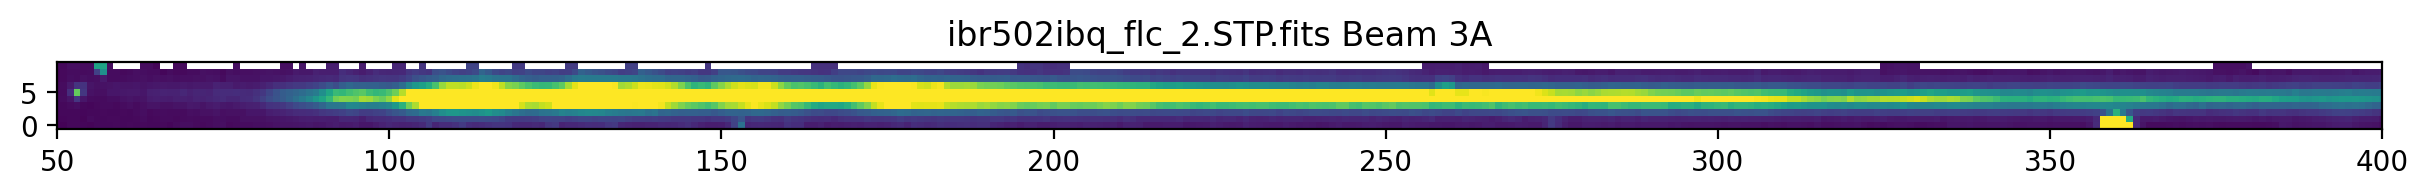

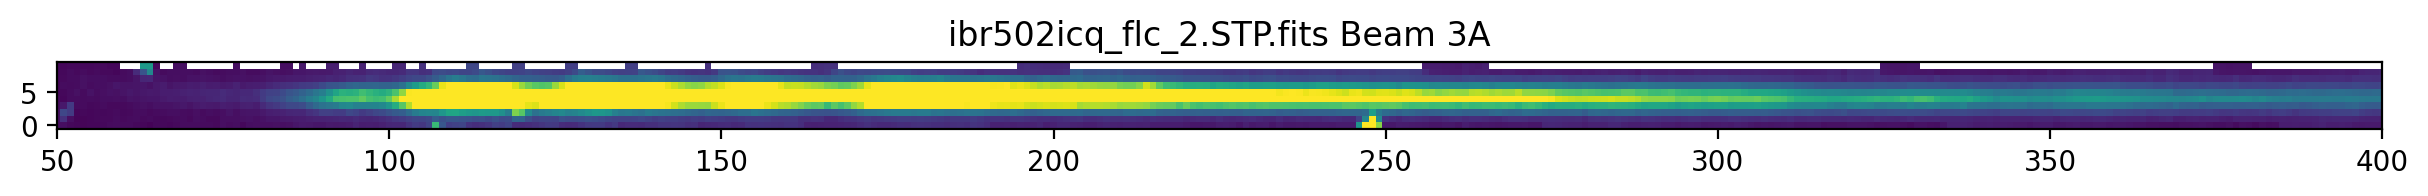

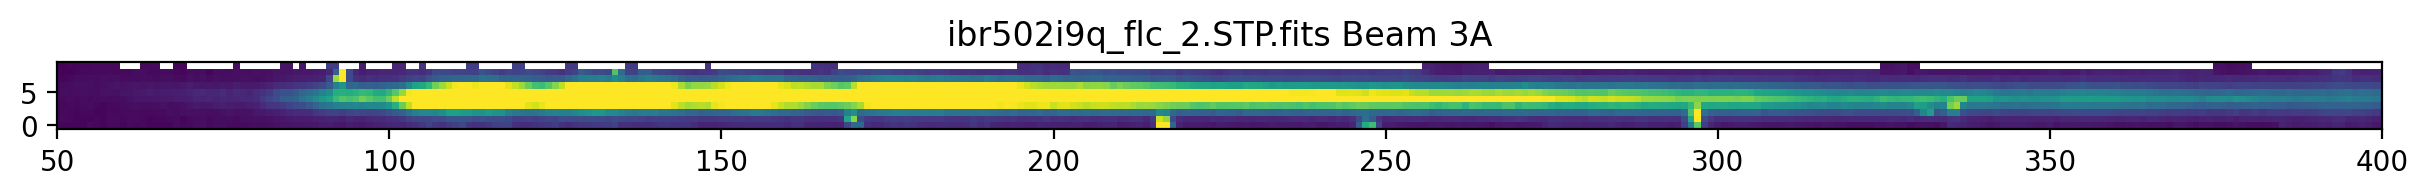

In [26]:
beam = '3A'

for i, f in enumerate(glob.glob('OUTPUT/*2.STP.fits')):
    with fits.open(f) as hdul:
        d = hdul[f'BEAM_{beam}'].data
    z1,z2 = zscale.zscale(d)
    plt.figure(figsize=(15,10),dpi=200)
    im = plt.imshow(d, origin='lower',vmin=z1, vmax=z2)
    plt.title(os.path.basename(f)+f' Beam {beam}')
    plt.xlim(50,400)


And now, the SPC files. For the example data, we show the spectrum of superluminous supernova PTF12dam from HST PID WFC3/GO [12524](https://www.stsci.edu/cgi-bin/get-proposal-info?id=12524&submit=Go&observatory=HST) (PI Quimby). For more information about the spectrum and what the blended spectral features are please see [Quimby et al. 2018](https://ui.adsabs.harvard.edu/abs/2018ApJ...855....2Q/abstract).

Text(0, 0.5, 'Flux ($erg/s/cm^2/\\AA$)')

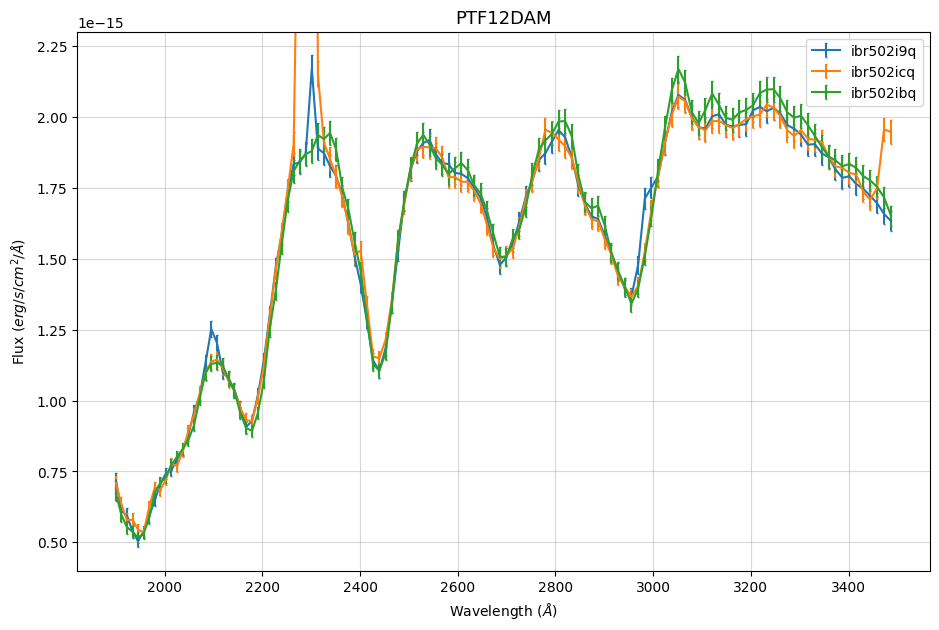

In [27]:
beam = '3A'

fig, ax = plt.subplots(1, 1, figsize=(11,7))
for i, f in enumerate(glob.glob('OUTPUT/*2.SPC.fits')):
    with fits.open(f) as hdul:
        d = hdul[f'BEAM_{beam}'].data
        h = hdul[0].header
        
    wl = d['LAMBDA']
    flux = d['FLUX']
    error = d['FERROR']
    xrange = (wl>1900) & (wl<3500)
    
    ax.errorbar(wl[xrange],flux[xrange],error[xrange],label=os.path.basename(f)[:9],capsize=1)

ax.legend()
ax.grid(alpha=0.5)
ax.set_ylim(4e-16,2.3e-15)
ax.set_xlabel(r'Wavelength ($\AA$)')
ax.set_title(f"{h['targname']}",size=13)
ax.set_ylabel(r'Flux ($erg/s/cm^2/\AA$)')        

## 5. Conclusions <a id="conclusions"></a>

Thank you for walking through this spectral extraction workflow. You should now be able to perform a basic extraction on WFC3/UVIS data using HSTaXe.

For additional information on the WFC3 grisms, please visit the [grism resources](https://www.stsci.edu/hst/instrumentation/wfc3/documentation/grism-resources) and [grism data analysis](https://www.stsci.edu/hst/instrumentation/wfc3/documentation/grism-resources/grism-data-analysis) webpages.

Further workflow cookbooks are available on the [HSTaXe GitHub](https://github.com/spacetelescope/HSTaXe), including a more advanced IR extraction, and a UVIS extraction. For detailed information on HSTaXe, please visit the [documentation webpage](https://hstaxe.readthedocs.io/en/latest/index.html).

Lastly, if you have questions regarding this notebook or using WFC3 data with HSTaXe please contact our WFC3 [Help Desk](https://stsci.service-now.com/hst).

**Congratulations, you have completed the notebook.**

## 6. About this Notebook <a id="about"></a>

**Author:** Benjamin Kuhn & Aidan Pidgeon WFC3 Instrument Team

**Special Thanks to:** 
 - Dr. Nor Pirzkal, for creating the original workflow that was adapted into this notebook
 - Ricky O'Steen and Duy Nguyen, for their fantastic work in updating the HSTaXe module
 - Debopam Som for support in testing the HSTaXe workflow

**Released:** February 13, 2023 <br>
**Last Updated:** March 31, 2023

## 7. Citations <a id="cite"></a>

If you use `astropy`, `drizzlepac`, `matplotlib` or `numpy` for published research, please cite the
authors. Follow this link for more information about citing the libraries:

* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `drizzlepac`](https://drizzlepac.readthedocs.io/en/latest/LICENSE.html)
* [Citing `matplotlib`](https://matplotlib.org/stable/users/project/citing.html)
* [Citing `numpy`](https://numpy.org/citing-numpy/)

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 